# Network Analysis of 'MiBici' Public Bike Service in Guadalajara's Metropolitan Area

## Authors:
Henry Marie MONT () and Matteo MATONE () 
University of Tartu, Department of Computer Science  
Tartu, Estonia  
Email: henry.marie.mont@ut.ee, matone@ut.ee

## Data exploration

### Import required libraries

In [23]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

### Load data

In [11]:
# Load MiBici dataset
mibici_df = pd.read_csv('data/mibici_2014-2024/mibici_2014-2024.csv')

# Load nomenclature dataset
nomenclature_df = pd.read_csv('data/nomenclature_2024.csv')

### Explore data

In [12]:
# Display basic information about the nomenclature dataset
print("\nNomenclature Dataset Information:")
print(nomenclature_df.info())

# Display the first few rows of the nomenclature dataset
print("\nFirst few rows of Nomenclature Dataset:")
print(nomenclature_df.head())

# Summary statistics of numerical columns in the nomenclature dataset
print("\nSummary statistics of numerical columns:")
print(nomenclature_df.describe())

# Check for missing values in the nomenclature dataset
print("\nMissing values in Nomenclature Dataset:")
print(nomenclature_df.isnull().sum())

# Display basic information about the MiBici dataset
print("MiBici Dataset Information:")
print(mibici_df.info())

# Display the first few rows of the MiBici dataset
print("\nFirst few rows of MiBici Dataset:")
print(mibici_df.head())

# Summary statistics of numerical columns in the MiBici dataset
print("\nSummary statistics of numerical columns:")
print(mibici_df.describe())

# Check for missing values in the MiBici dataset
print("\nMissing values in MiBici Dataset:")
print(mibici_df.isnull().sum())


Nomenclature Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         372 non-null    int64  
 1   name       372 non-null    object 
 2   obcn       372 non-null    object 
 3   location   372 non-null    object 
 4   latitude   372 non-null    float64
 5   longitude  372 non-null    float64
 6   status     372 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 20.5+ KB
None

First few rows of Nomenclature Dataset:
   id                                           name     obcn  \
0   2  (GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.  GDL-001   
1   3     (GDL-002) C. Colonias  / Av.  Niños héroes  GDL-002   
2   4          (GDL-003) C. Vidrio / Av. Chapultepec  GDL-003   
3   5           (GDL-004) C. Ghilardi /C. Miraflores  GDL-004   
4   6  (GDL-005) C. San Diego /Calzada Independencia  GDL-005   

 

In [13]:
# Display unique values for the 'location' column
unique_locations = nomenclature_df['location'].unique()
print("Unique values for 'location' column:")
print(unique_locations)

# Display unique values for the 'status' column
unique_statuses = nomenclature_df['status'].unique()
print("Unique values for 'status' column:")
print(unique_statuses)

Unique values for 'location' column:
['POLÍGONO CENTRAL' 'ZAPOPAN CENTRO' 'TLQ-CORREDORATLAS']
Unique values for 'status' column:
['IN_SERVICE' 'NOT_IN_SERVICE']


### Data preprocessing

In [14]:
# Let's first prune the data as it was way too long to work on those 2.4 GB of data with our machines

# Let's try to keep 1/10th of the data
fraction_to_keep = 0.01

# Calculate the number of rows to keep for each dataset
num_rows_mibici = int(len(mibici_df) * fraction_to_keep)

# Randomly select a subset of rows for each dataset
pruned_mibici_df = mibici_df.sample(n=num_rows_mibici, random_state=42)

# Print the shape of the pruned datasets
print("Shape of pruned MiBici dataset:", pruned_mibici_df.shape)

Shape of pruned MiBici dataset: (258636, 11)


In [15]:
# Drop stations that are 'NOT_IN_SERVICE'
nomenclature_df = nomenclature_df[nomenclature_df['status'] != 'NOT_IN_SERVICE']

# Drop the columns 'obcn', 'location', and 'status'
nomenclature_df.drop(columns=['obcn', 'location', 'status'], inplace=True)

In [16]:
# Convert 'Trip_start' and 'Trip_end' columns to datetime objects
pruned_mibici_df['Trip_start'] = pd.to_datetime(pruned_mibici_df['Trip_start'])
pruned_mibici_df['Trip_end'] = pd.to_datetime(pruned_mibici_df['Trip_end'])

# Convert 'Duration' column to numerical format (seconds)
pruned_mibici_df['Duration'] = pd.to_timedelta(pruned_mibici_df['Duration']).dt.total_seconds()

# Extract additional features from datetime columns
pruned_mibici_df['Day_of_week'] = pruned_mibici_df['Trip_start'].dt.dayofweek
pruned_mibici_df['Hour_of_day'] = pruned_mibici_df['Trip_start'].dt.hour
pruned_mibici_df['Month'] = pruned_mibici_df['Trip_start'].dt.month

# Drop unnecessary columns
pruned_mibici_df.drop(columns=['Unnamed: 0', 'User_Id', 'Sex', 'Birth_year', 'Age'], inplace=True)

### Display pre-processed data

In [17]:
# Display basic information about the nomenclature dataset
print("\nNomenclature Dataset Information:")
print(nomenclature_df.info())

# Display the first few rows of the nomenclature dataset
print("\nFirst few rows of Nomenclature Dataset:")
print(nomenclature_df.head())

# Display basic information about the MiBici dataset
print("MiBici Dataset Information:")
print(pruned_mibici_df.info())

# Display the first few rows of the MiBici dataset
print("\nFirst few rows of MiBici Dataset:")
print(pruned_mibici_df.head())


Nomenclature Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 359 entries, 0 to 371
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         359 non-null    int64  
 1   name       359 non-null    object 
 2   latitude   359 non-null    float64
 3   longitude  359 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 14.0+ KB
None

First few rows of Nomenclature Dataset:
   id                                           name   latitude   longitude
0   2  (GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.  20.666378 -103.348820
1   3     (GDL-002) C. Colonias  / Av.  Niños héroes  20.667228 -103.366000
2   4          (GDL-003) C. Vidrio / Av. Chapultepec  20.667690 -103.368252
3   5           (GDL-004) C. Ghilardi /C. Miraflores  20.691750 -103.362550
4   6  (GDL-005) C. San Diego /Calzada Independencia  20.681158 -103.339363
MiBici Dataset Information:
<class 'pandas.core.frame.DataFra

## Building network

In [18]:
# Initialize an empty directed graph
G = nx.DiGraph()

# Add nodes (stations) to the graph from the Nomenclature dataset
for idx, row in nomenclature_df.iterrows():
    G.add_node(row['id'], name=row['name'], latitude=row['latitude'], longitude=row['longitude'])

# Add edges (bike trips) to the graph from the MiBici dataset
for idx, row in pruned_mibici_df.iterrows():
    origin_id = row['Origin_Id']
    destination_id = row['Destination_Id']
    if G.has_node(origin_id) and G.has_node(destination_id):
        # Check if both origin and destination stations exist in the graph
        if G.has_edge(origin_id, destination_id):
            # If an edge already exists, increment the weight (number of trips)
            G[origin_id][destination_id]['weight'] += 1
        else:
            # If no edge exists, add a new edge with weight 1
            G.add_edge(origin_id, destination_id, weight=1)

# Print some basic information about the graph
print("Number of nodes (stations):", G.number_of_nodes())
print("Number of edges (bike trips):", G.number_of_edges())

Number of nodes (stations): 359
Number of edges (bike trips): 37349


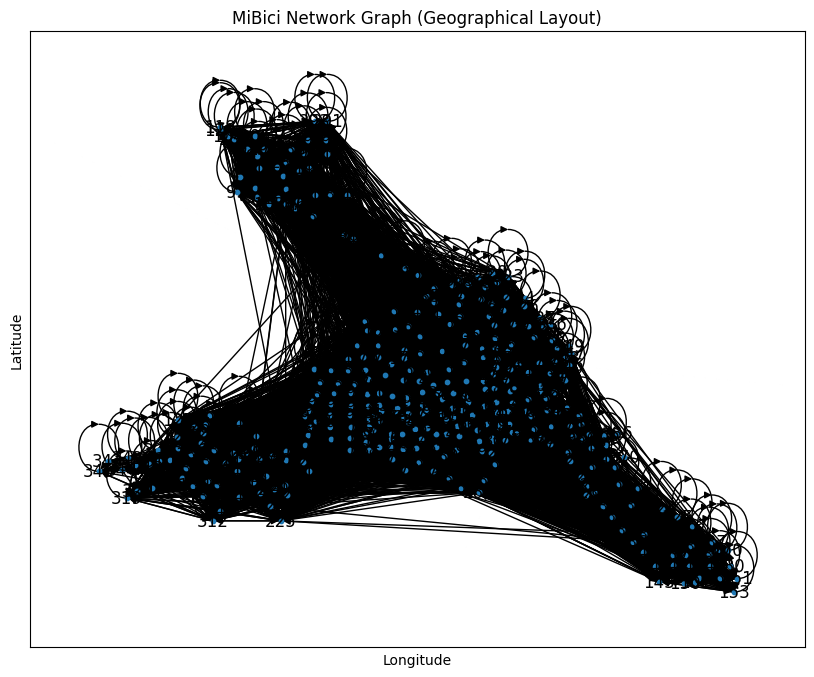

In [21]:
# Define positions for nodes based on latitude and longitude
node_positions = {node_id: (data['longitude'], data['latitude']) for node_id, data in G.nodes(data=True)}

# Draw the network graph with nodes positioned according to latitude and longitude
plt.figure(figsize=(10, 8))
nx.draw_networkx(G, pos=node_positions, with_labels=True, node_size=10)
plt.title('MiBici Network Graph (Geographical Layout)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Preprocessing nodes in the graph

In [22]:
# Calculate the average degree of the graph
average_degree = sum(dict(G.degree()).values()) / len(G)

print("Average degree of the graph:", average_degree)

Average degree of the graph: 208.07242339832868


In [24]:
# Get the degrees of nodes in the graph
degrees = list(dict(G.degree()).values())

# Calculate the lower quartile (Q1) using numpy's percentile function
lower_quartile = np.percentile(degrees, 25)

print("Lower quartile (Q1) of the node degrees:", lower_quartile)

Lower quartile (Q1) of the node degrees: 74.0


In [25]:
# Remove disconnected nodes
G.remove_nodes_from(list(nx.isolates(G)))

# Remove nodes with a low number of edges (e.g., less than 2)
nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree < 74]
G.remove_nodes_from(nodes_to_remove)

# Print some basic information about the graph after pre-processing
print("Number of nodes after pre-processing:", G.number_of_nodes())
print("Number of edges after pre-processing:", G.number_of_edges())

Number of nodes after pre-processing: 272
Number of edges after pre-processing: 35020


In [26]:
# Create an empty graph
G_by_year = nx.Graph()

# Group the DataFrame by origin, destination, and year
grouped_df = pruned_mibici_df.groupby(['Origin_Id', 'Destination_Id', pruned_mibici_df['Trip_start'].dt.year])

# Iterate over each group
for (origin, destination, year), group_data in grouped_df:
    # Calculate the total number of trips for this group
    total_trips = len(group_data)
    
    # Check if an edge between the origin and destination already exists
    if G_by_year.has_edge(origin, destination):
        # Check if an edge with the specified year exists
        if G_by_year[origin][destination].get(year):
            # If the edge with the specified year exists, update its weight
            G_by_year[origin][destination][year]['weight'] += total_trips
        else:
            # If the edge with the specified year does not exist, add a new edge
            G_by_year.add_edge(origin, destination, year=year, weight=total_trips)
    else:
        # If the edge between the origin and destination does not exist, add a new edge
        G_by_year.add_edge(origin, destination, year=year, weight=total_trips)

# Print the number of nodes and edges for the graph by year
print("Graph based on year: Nodes:", G_by_year.number_of_nodes(), "Edges:", G_by_year.number_of_edges())


Graph based on year: Nodes: 372 Edges: 23329


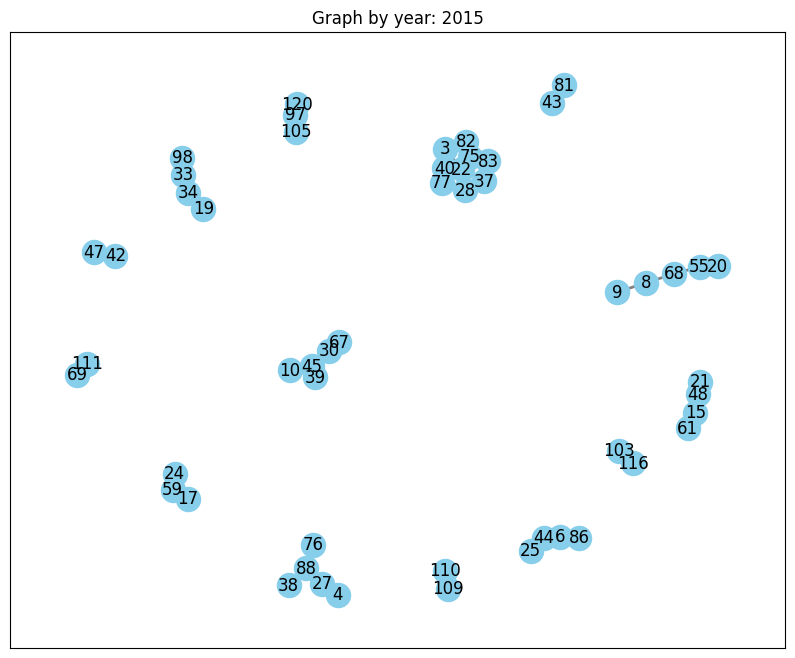

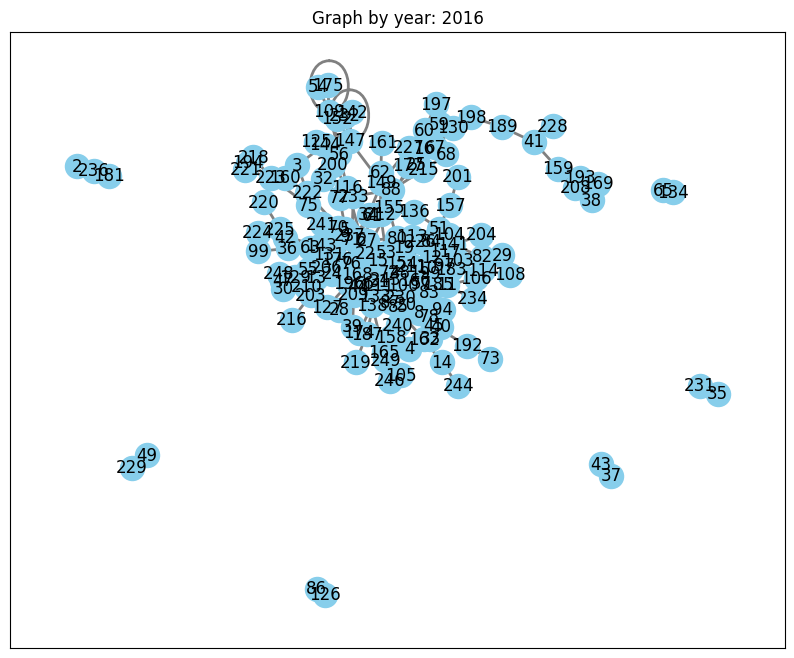

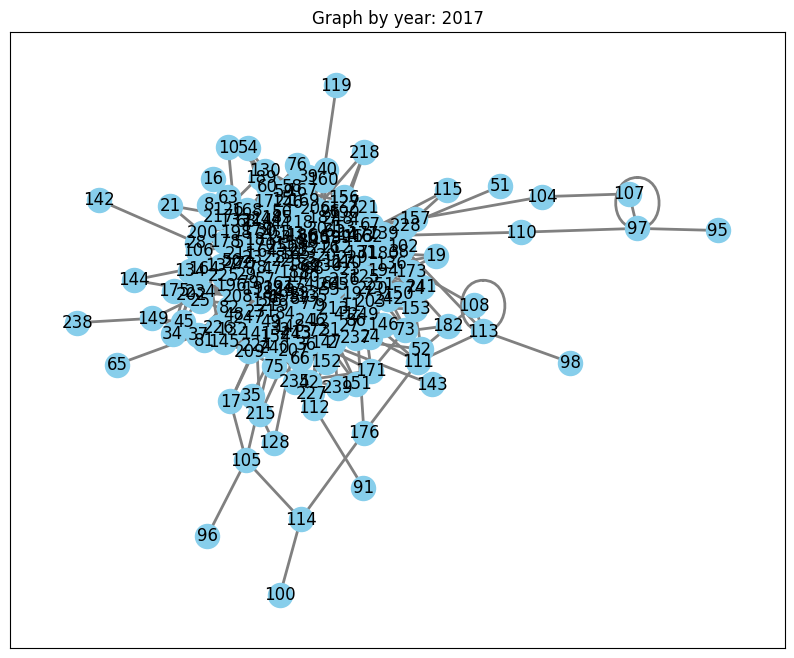

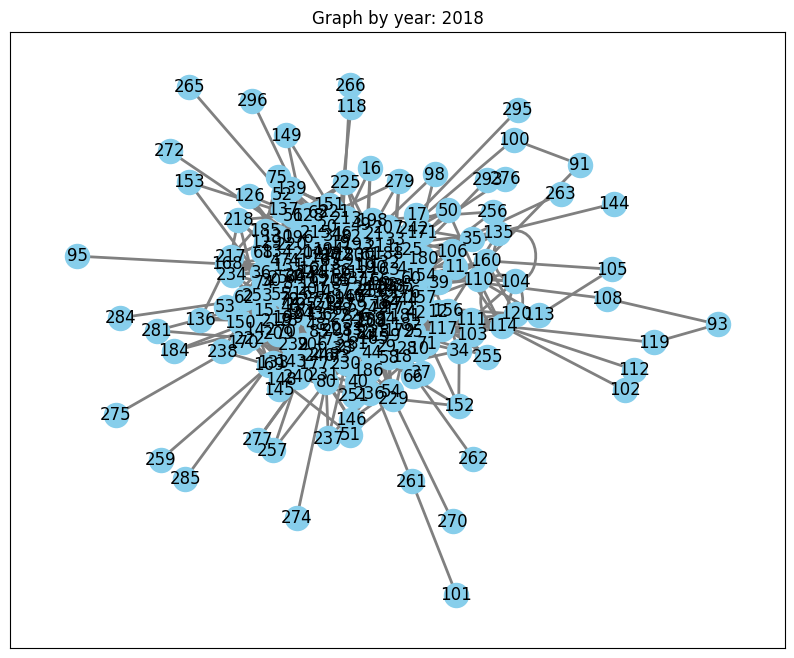

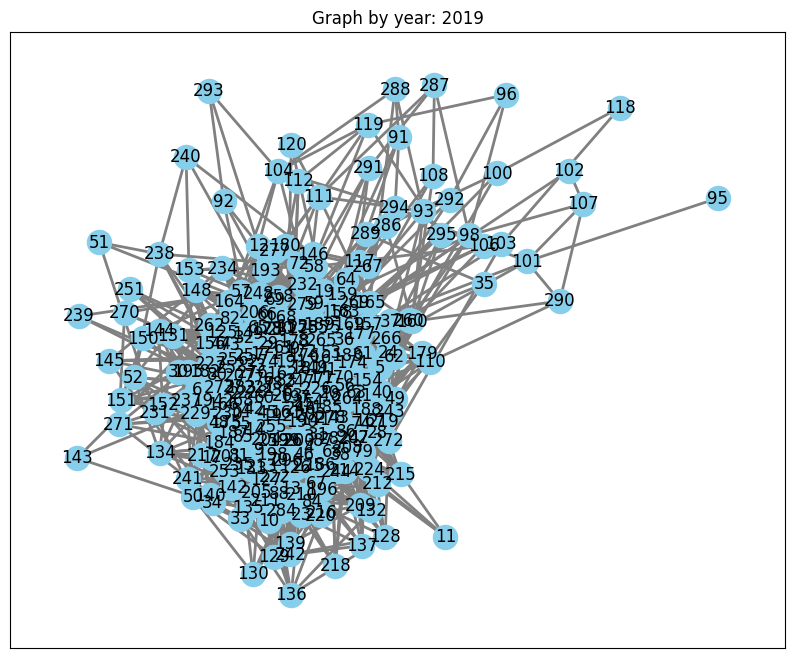

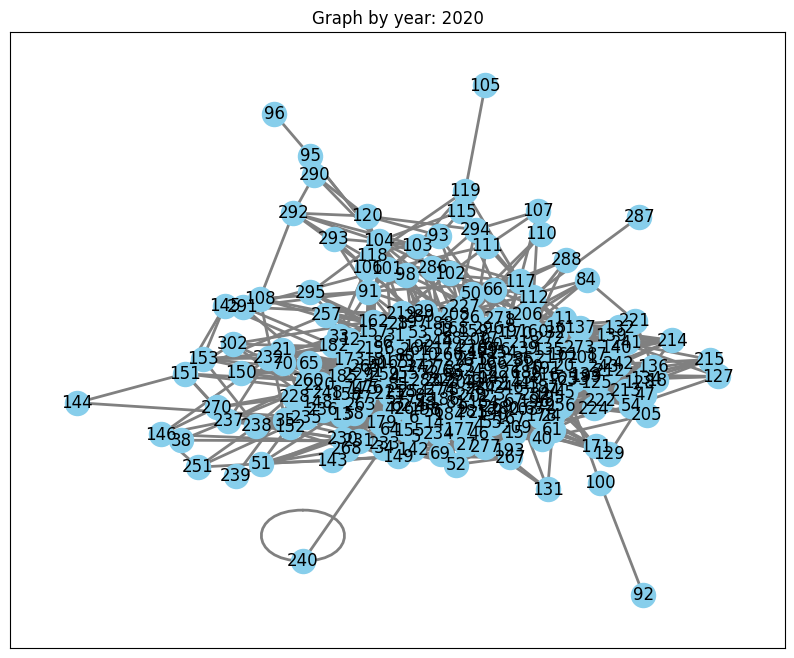

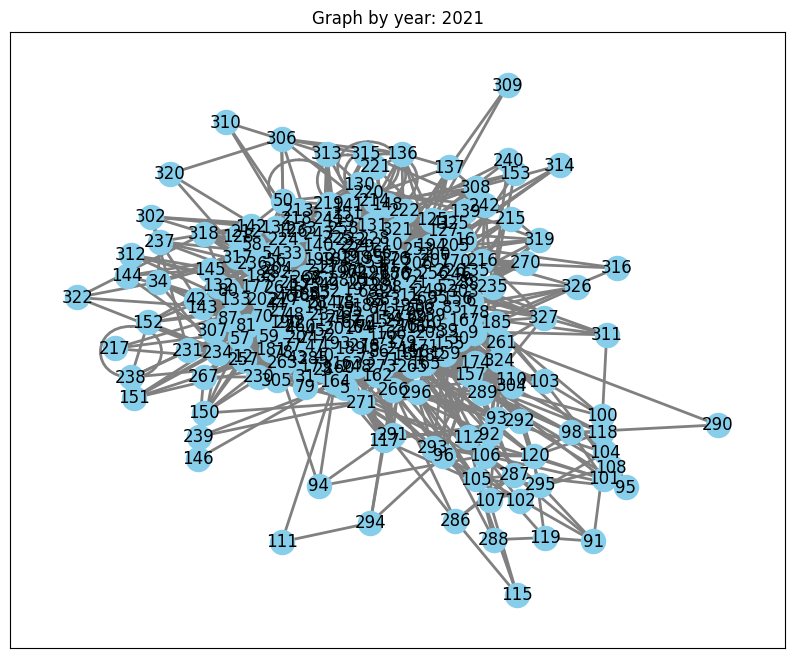

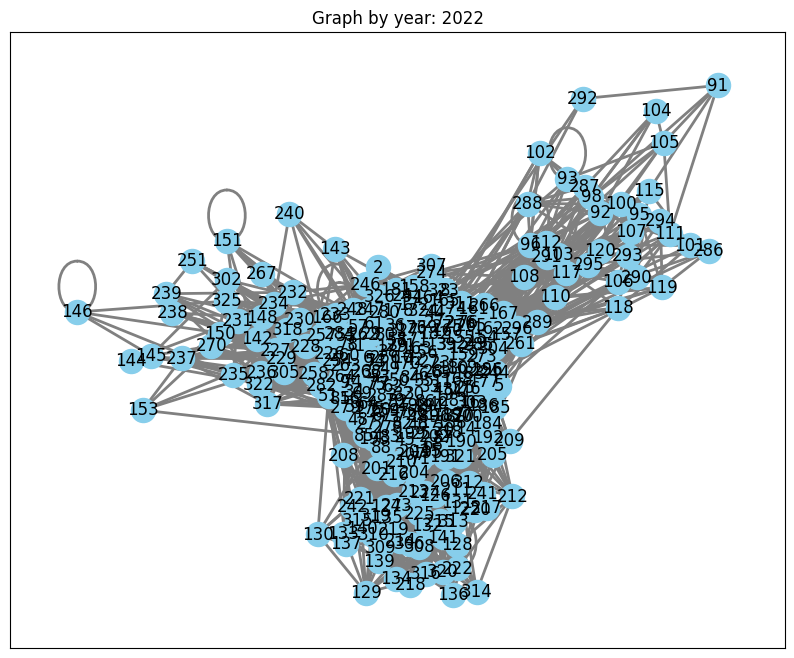

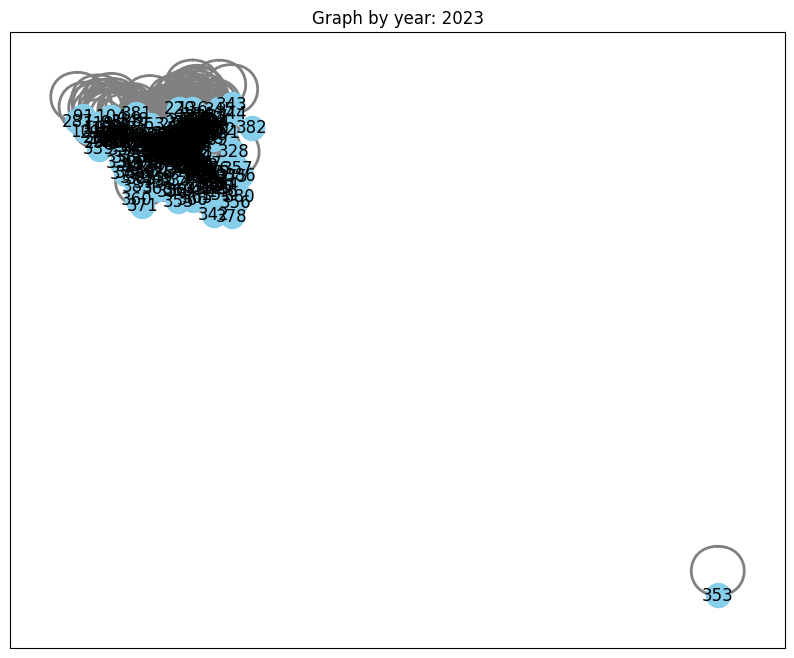

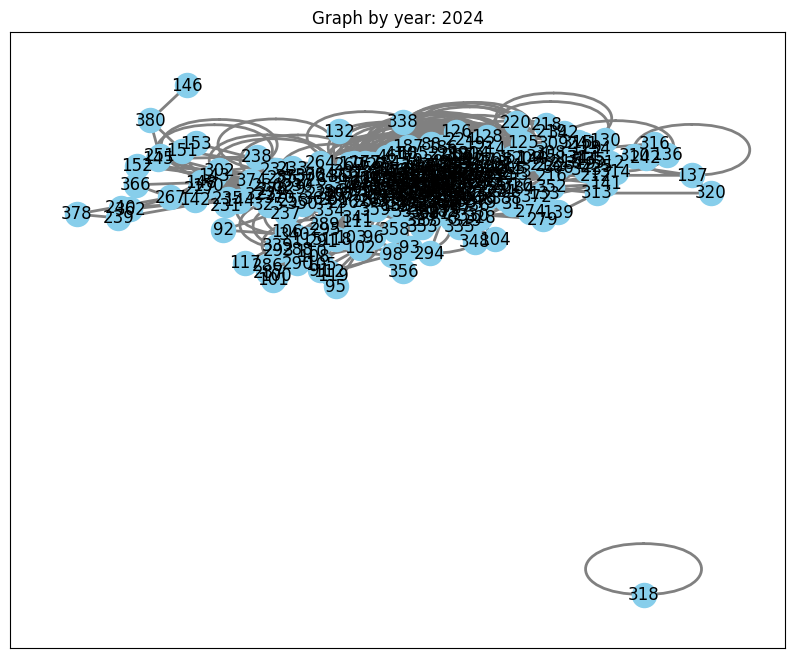

In [28]:
# Get a list of unique years
unique_years = sorted(set(nx.get_edge_attributes(G_by_year, 'year').values()))

# Plot the graph for each year
for year in unique_years:
    # Create a subgraph containing edges from the given year
    subgraph_edges = [(u, v) for u, v, attrs in G_by_year.edges(data=True) if attrs['year'] == year]
    subgraph = G_by_year.edge_subgraph(subgraph_edges)
    
    # Draw the subgraph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subgraph)  # Define the layout (you can use other layouts as well)
    nx.draw_networkx(subgraph, pos, with_labels=True, node_size=300, node_color='skyblue', edge_color='gray', width=2)
    plt.title(f"Graph by year: {year}")
    plt.show()